In [133]:
# Global imports
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [134]:
from pymongo import MongoClient

# Connect to local MongoDB database
client = MongoClient("mongodb://localhost:27017")

# Create/access feature descriptor collection
db = client["knravish_mwdb_phase_1"]
fd_collection = db["fd_collection"]


### Loading Caltech101 dataset

In [135]:
import torchvision.datasets as datasets

dataset_path = "C:\Kaushik\ASU\CSE 515 - Multimedia and Web Databases\Project\Phase 1\Datasets"

dataset = datasets.Caltech101(
    root=dataset_path,
    download=False,  # True if downloading for first time
)


Select image by ID

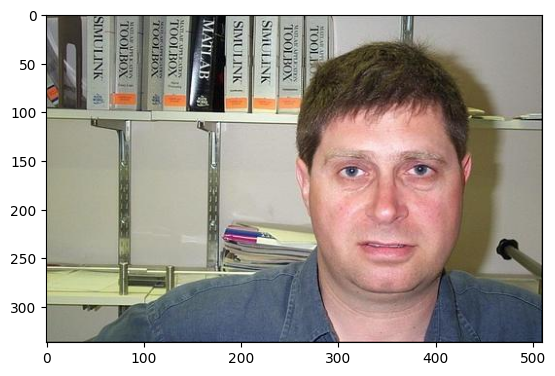

In [77]:
selected_image_id = int(input("Enter image ID: "))
k = int(input("Enter value of k: "))
if k < 1:
	raise ValueError("k should be positive integer")
sample_image, sample_label = dataset[selected_image_id]
plt.imshow(sample_image)
plt.show()


In [184]:
def euclidean_distance_measure(img_1_fd, img_2_fd, target_shape):
    # Reshape and take L2 norm between the moments (Euclidean distance)
    img_1_fd_reshaped = img_1_fd.reshape(target_shape)
    img_2_fd_reshaped = img_2_fd.reshape(target_shape)

    return np.linalg.norm(img_1_fd_reshaped - img_2_fd_reshaped, axis=1)


In [209]:
def cosine_distance_measure(img_1_fd, img_2_fd, target_shape):
    img_1_fd_reshaped = img_1_fd.reshape(target_shape)
    img_2_fd_reshaped = img_2_fd.reshape(target_shape)
    
    # Calculate dot product
    dot_product = np.dot(img_1_fd_reshaped, img_2_fd_reshaped.T)
    print(dot_product)

    # Calculate magnitude (L2 norm) along each row of the feature descriptor
    magnitude1 = np.linalg.norm(img_1_fd_reshaped, axis=1)
    magnitude2 = np.linalg.norm(img_2_fd_reshaped, axis=1)

    print(magnitude1)
    print(magnitude2)

    # Calculate cosine similarity
    return dot_product / (magnitude1[:, np.newaxis] * magnitude2)


In [161]:
valid_feature_models = ["cm", "hog", "avgpool", "layer3", "fc"]

In [213]:
def show_similar_images(target_image_id, k, feature_model, distance_measure):
    min_dists = {target_image_id: 0}
    target_image = fd_collection.find_one({"image_id": target_image_id})
    target_image_fd = np.array(target_image[feature_model + "_fd"])

    reshape_mappings = {
        "cm": {
            "euclidean": (100, 9),
        },
        "hog": {
            "euclidean": (100, 9),
            "cosine": (100, 9),
        },
    }
    assert (
        feature_model in valid_feature_models
    ), "feature_model should be one of " + str(valid_feature_models)

    # only RGB for non RGB images
    if feature_model is not "hog":
        all_images = fd_collection.find({"channels": 3})
    else:
        all_images = fd_collection.find()

    for cur_img in all_images:
        cur_img_id = cur_img["image_id"]
        cur_img_fd = np.array(cur_img[feature_model + "_fd"])
        cur_dist = distance_measure(
            cur_img_fd,
            target_image_fd,
            reshape_mappings[
                feature_model[distance_measure.__name__.split("_")[0]]
            ],  # TODO: bit fancy innit
        )

        # store first k images irrespective of distance
        if len(min_dists) < k + 1:
            min_dists[cur_img_id] = cur_dist
        # if lower distance:
        elif cur_dist < max(min_dists.values()):
            # add to min_dists
            min_dists.update({cur_img_id: cur_dist})
            # remove greatest distance by index
            min_dists.pop(max(min_dists, key=min_dists.get))

    print(min_dists.items())

    fig, axes = plt.subplots(1, k + 1, figsize=(16, 8))
    for idx, (img_id, distance) in enumerate(min_dists.items()):
        cur_img, _cur_label = dataset[img_id]
        axes[idx].imshow(cur_img)
        axes[idx].set_title(f"Distance: {distance}")
    plt.axis("off")
    plt.show()
